In [ ]:
!apt-get install unzip wget -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!pip install transformers
!pip install -U sentence-transformers
!pip3 install torch torchvision
!pip install pymorphy2

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.7/dist-packages (1.1.1)


In [ ]:
!pip3 install nltk

In [ ]:
import torch
from torch.utils.data import TensorDataset, random_split, RandomSampler, DataLoader, SequentialSampler
from torchtext import data
from transformers import AutoTokenizer, AutoModel

In [ ]:
!pip freeze | grep torch

torch==1.8.1+cu101
torchsummary==1.5.1
torchtext==0.9.1
torchvision==0.9.1+cu101


In [1]:
import pandas as pd

def get_dateset(path):  
  dataset = pd.read_csv(path)
  return dataset

In [ ]:
dataset = get_dataset('/content/drive/MyDrive/Colab Notebooks/Distillation/distillation100000.csv')

In [ ]:
dataset.head()

,title,topic
0,Правительство России намерено стимулировать ук...,Экономика
1,"Кинорежиссер Майкл Мур заявил, что будет добив...",Культура
2,Главному тренеру сборной Белоруссии по футболу...,Спорт
3,В понедельник утром в городе Елизово Камчатско...,Россия
4,На вершине горы Фудзияма скоро появятся биотуа...,Из жизни


In [ ]:
# приведение к нижнему регистру
def to_lower(sen):
  return sen.lower()

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokens, texts):
        self.tokens = tokens
        self.texts = texts

    def __len__(self):
        return len(self.texts)
    def __getitem__(self, index):
        return self.tokens[index], self.texts[index]

In [ ]:
# конвертация к формату torch.tensor
def to_dataset(x, y):
    torch_x = torch.tensor(x, dtype=torch.long)
    return CustomDataset(torch_x, y)

In [ ]:
# изменение устройства
def device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_device(text, real_label):
    text = text.to(device())
    real_label = real_label.to(device())
    return text, real_label

In [ ]:
# Подгружаем SBERT-модель и SBERT-токенайзер 
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model_teacher = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model_teacher.to(device())

In [ ]:
# функция подсчета количества весов у модели
def get_weights(model):
  number = 0
  for key in model.state_dict():
    number += model.state_dict()[key].shape[0]
  return number

In [ ]:
from tqdm import tqdm


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def embedd(texts):
  max_len=20
  X_encoded = tokenizer(list(texts), padding='max_length', truncation=True, max_length=max_len, return_tensors='pt').to(device())
  with torch.no_grad():
    model_output = model_teacher(**X_encoded)
    sentence_embeddings = mean_pooling(model_output, X_encoded['attention_mask']).to(device())
  return sentence_embeddings

def tokenized(texts):
  max_len = 20
  X_encoded = tokenizer(texts, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt').to(device())
  return X_encoded['input_ids'], X_encoded

In [ ]:
from torch import nn
from torch.autograd import Variable


# Модель-ученик
class SimpleLSTM(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, batch_size, device=None):
        super(SimpleLSTM, self).__init__()
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.device = self.init_device(device)
        self.hidden = self.init_hidden()

    @staticmethod
    def init_device(device):
        if device is None:
            return torch.device('cuda')
        return device

    def init_hidden(self):
        return (Variable(torch.zeros(2 * self.n_layers, self.batch_size, self.hidden_dim).to(self.device)),
                Variable(torch.zeros(2 * self.n_layers, self.batch_size, self.hidden_dim).to(self.device)))

    def forward(self, text, text_lengths=None):
        self.hidden = self.init_hidden()
        x = self.embedding(text)
        x, self.hidden = self.rnn(x, self.hidden)
        hidden, cell = self.hidden
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        x = self.fc(hidden)
        return x

In [ ]:
def get_optimizer(model):
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.9)
    return optimizer, scheduler


def epoch_train_func(model, dataset, loss_func, batch_size):
    train_loss = 0
    train_sampler = RandomSampler(dataset)
    data_loader = DataLoader(dataset, sampler=train_sampler,
                             batch_size=batch_size,
                             drop_last=True)
    model.train()
    optimizer, scheduler = get_optimizer(model)
    for i, (tokens, pre_embedding) in enumerate(data_loader): 
        embedding = embedd(pre_embedding)
        tokens, embedding = to_device(tokens, embedding)
        model.zero_grad()
        output = model(tokens.t(), None).squeeze(1)
        loss = loss_func(output, embedding)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step()
    return train_loss / len(data_loader)

def epoch_evaluate_func(model, eval_dataset, loss_func, batch_size):
    eval_sampler = SequentialSampler(eval_dataset)
    data_loader = DataLoader(eval_dataset, sampler=eval_sampler,
                             batch_size=batch_size,
                             drop_last=True)

    eval_loss = 0.0
    model.eval()
    for i, (tokens, pre_embedding) in enumerate(data_loader):
        embedding = embedd(pre_embedding)
        tokens, embedding = to_device(tokens, embedding)
        output = model(tokens.t(), None).squeeze(1)
        loss = loss_func(output, embedding)
        eval_loss += loss.item()
    return eval_loss / len(data_loader)

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import os


class LSTMBaseline(object):
    vocab_name = 'distillation_model.pt'

    def __init__(self, settings, path):
        self.settings = settings
        self.criterion = torch.nn.MSELoss().to(device())
        self.weights_name = path

    def loss(self, student_embedding, teacher_embedding):
        return self.criterion(student_embedding, teacher_embedding)

    def model(self, text_field):
        model = SimpleLSTM(
            input_dim=len(text_field.vocab),
            embedding_dim=50,
            hidden_dim=1024,
            output_dim=1024,
            n_layers=2,
            bidirectional=True,
            dropout=0.2,
            batch_size=32)
        return model

    def train(self, data, output_dir, tokenizer):        
        X, y = tokenized(list(data.title.apply(to_lower)))

        dataset = to_dataset(X, list(data.title.apply(to_lower)))

        val_len = int(len(data) * 0.02)
        train_dataset, val_dataset = random_split(dataset, (len(dataset) - val_len, val_len))

        model_student = self.model(tokenizer)
        model_student.to(device())


        self.full_train(model_student, train_dataset, val_dataset, output_dir)

    def show_training(self, loss_values, val_loss_values):

        epochs = range(1, settings['num_train_epochs'] + 1)

        plt.plot(epochs, loss_values, 'bo', label='Training loss')
        plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

    def full_train(self, model_student, train_dataset, val_dataset, output_dir):

        train_loss_list = []
        eval_loss_list = []


        train_settings = self.settings
        num_train_epochs = train_settings['num_train_epochs']
        best_eval_loss = None
        
        # цикл по "num_train_epochs" 
        for j in tqdm(range(num_train_epochs), "epoch"):
          
          train_loss = epoch_train_func(model_student, train_dataset, self.loss, self.settings['train_batch_size'])
          eval_loss = epoch_evaluate_func(model_student, val_dataset, self.loss, self.settings['eval_batch_size'])


          train_loss_list.append(train_loss)
          eval_loss_list.append(eval_loss)

          if best_eval_loss == None or eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            torch.save(model_student.state_dict(), os.path.join(output_dir, self.weights_name))


        self.show_training(train_loss_list, eval_loss_list)
        

In [ ]:
# количество предложений в выборке
DATASET_SIZE = 105000

In [ ]:

settings = {
    'train_batch_size' : 32,
    'num_train_epochs' : 15,
    'eval_batch_size': 32,
    
}

In [ ]:
baseline = LSTMBaseline(settings, '15_epoch_simple_lstm_100.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
epoch: 100%|██████████| 15/15 [3:20:41<00:00, 802.76s/it]


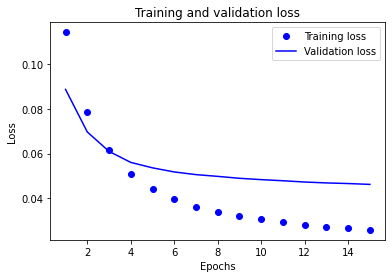

In [ ]:
baseline.train(dataset[:DATASET_SIZE], '/content/drive/MyDrive/Colab Notebooks/Distillation', tokenizer)

In [ ]:
# чистка кеша
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

2723